### **Problem Statement:**
Design and build a scalable machine learning pipeline to predict given consumer complaint will 	be disputed or not.

Since Our original datset is having 76% of unlabelled data we will use it for testing and we will build the model onn remaing 24% of the data.

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU, PReLU, ELU, ReLU
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Reading the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep learning/Dataset/Sample.csv")

In [ ]:
# Droping the coulmns which we are not going to use
df = df.drop(columns=["Date received","ZIP code", "Date sent to company", "Complaint ID"])

In [ ]:
# Printing the 5 sample to get overview
df.sample(5)

,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,Tags,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
446463,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,I received an auto loan from Exeter Finance on...,NaN,Exeter Finance Corp.,TX,NaN,Consent provided,Web,Closed with explanation,Yes,No
240439,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,NaN,NaN,Web,Closed with explanation,Yes,No
355509,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,Company chooses not to provide a public response,Experian Information Solutions Inc.,CA,NaN,Consent not provided,Web,Closed with explanation,Yes,No
669615,Consumer Loan,Vehicle loan,Shopping for a loan or lease,NaN,NaN,NaN,"General Motors Financial Company, Inc.",TX,NaN,NaN,Web,Closed with explanation,Yes,No
610521,Credit card,NaN,Credit line increase/decrease,NaN,NaN,NaN,"CITIBANK, N.A.",NY,NaN,NaN,Web,Closed with explanation,Yes,No


In [ ]:
# Shape of the dataset
df.shape

(768427, 14)

In [ ]:
# All the columns in the dataset
df.columns

Index(['Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'Tags', 'Consumer consent provided?', 'Submitted via',
       'Company response to consumer', 'Timely response?',
       'Consumer disputed?'],
      dtype='object')

In [ ]:
# Checking the percentage of nan values
df.isna().mean()

Product                         0.000000
Sub-product                     0.306030
Issue                           0.000000
Sub-issue                       0.592639
Consumer complaint narrative    0.786507
Company public response         0.745312
Company                         0.000000
State                           0.007353
Tags                            0.858808
Consumer consent provided?      0.612352
Submitted via                   0.000000
Company response to consumer    0.000000
Timely response?                0.000000
Consumer disputed?              0.000000
dtype: float64

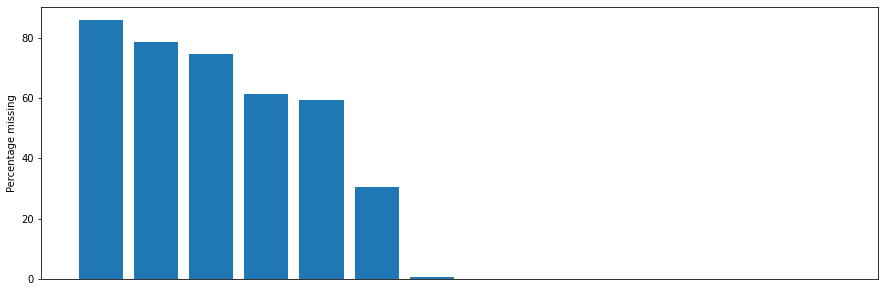

In [ ]:
# Ploting the missing values in percentage
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

### **Dropping the coulmns Having missing values more than 75%**

In [ ]:
# Dropping the coulmns Having missing values more than 75%
df = df.drop(columns=["Consumer complaint narrative","Tags"])

In [ ]:
# data types of each columns
df.dtypes

Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Company public response         object
Company                         object
State                           object
Consumer consent provided?      object
Submitted via                   object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
dtype: object

In [ ]:
# Checking the number of columns
df.shape

(768427, 12)

# EDA 
* **Univariate analysis for categorical data**

In [ ]:
# Number of unique categories in each column
df.nunique()

Product                           13
Sub-product                       50
Issue                             99
Sub-issue                         61
Company public response           10
Company                         4282
State                             62
Consumer consent provided?         4
Submitted via                      6
Company response to consumer       7
Timely response?                   2
Consumer disputed?                 2
dtype: int64

In [ ]:
# sepreating the columns
cat_var = list(df.columns)
cat_var.remove("Consumer disputed?")
cat_var

['Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Company public response',
 'Company',
 'State',
 'Consumer consent provided?',
 'Submitted via',
 'Company response to consumer',
 'Timely response?']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

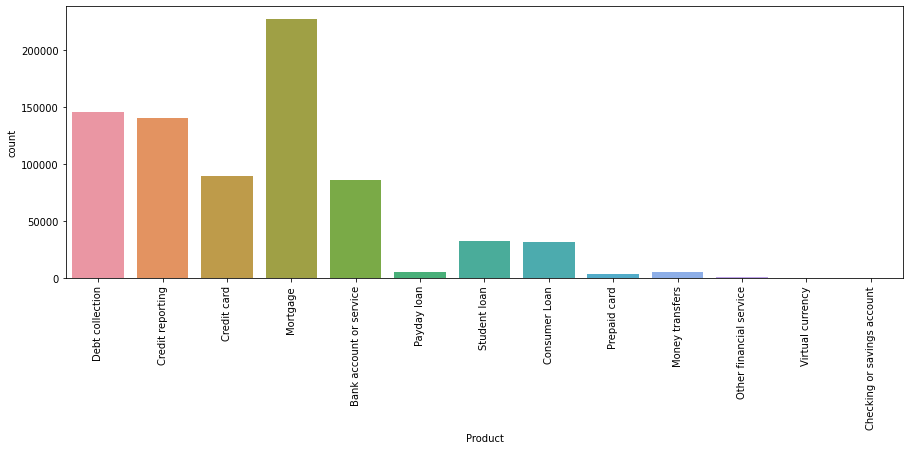

In [ ]:
# Ploting the Product column
plt.figure(figsize=(15, 5))
sns.countplot(x=df[cat_var[0]])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

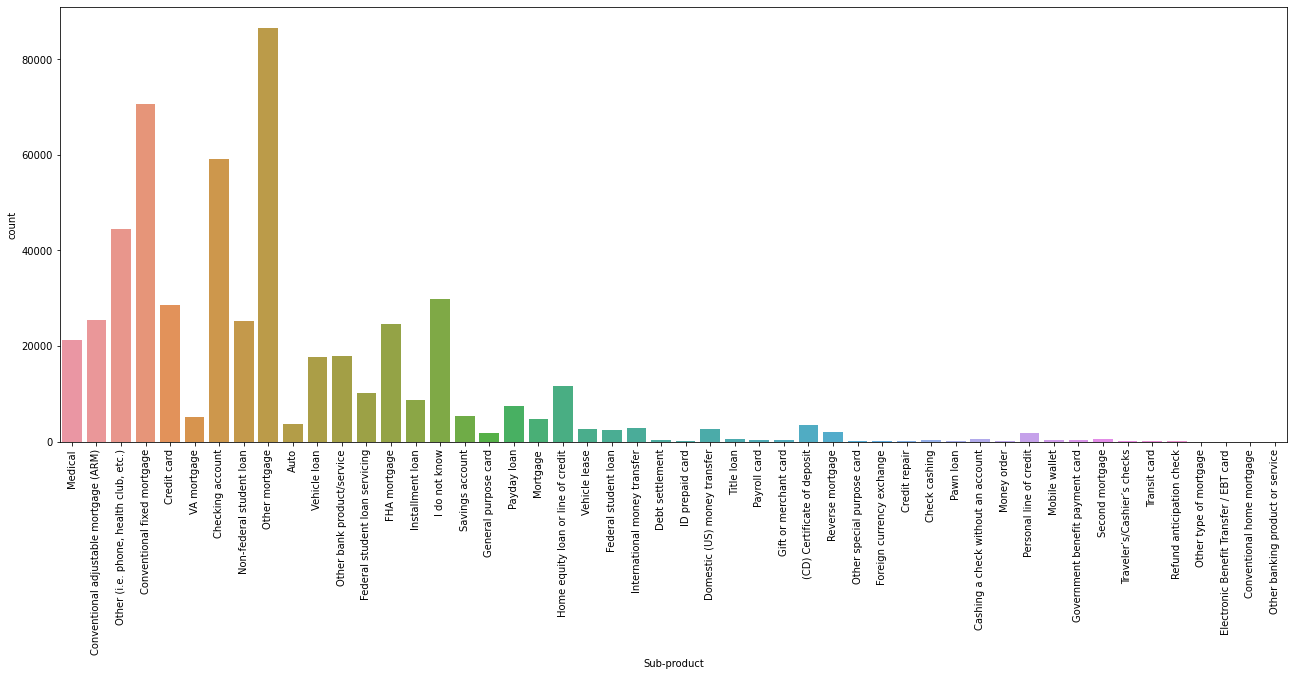

In [ ]:
# Ploting the Sub-Product column
plt.figure(figsize=(22, 8))
sns.countplot(x=df[cat_var[1]])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]),
 <a list of 99 Text major ticklabel objects>)

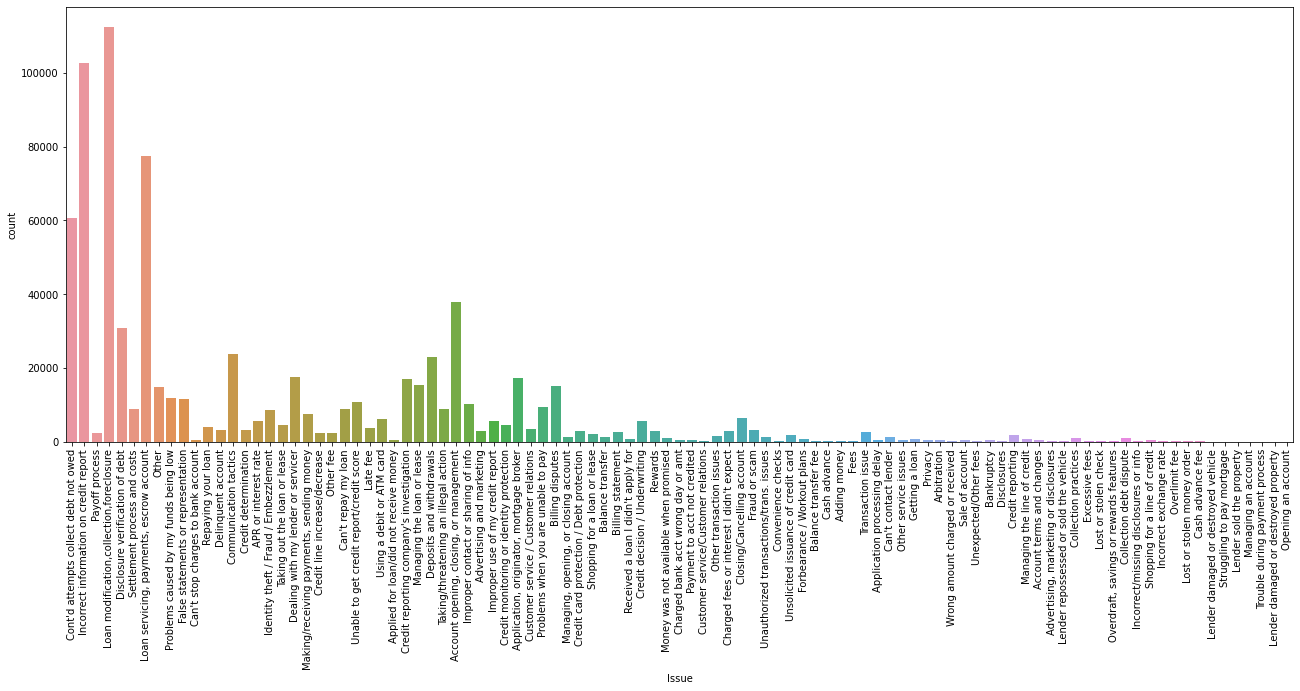

In [ ]:
# Ploting the Issue column
plt.figure(figsize=(22, 8))
sns.countplot(x=df[cat_var[2]])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text major ticklabel objects>)

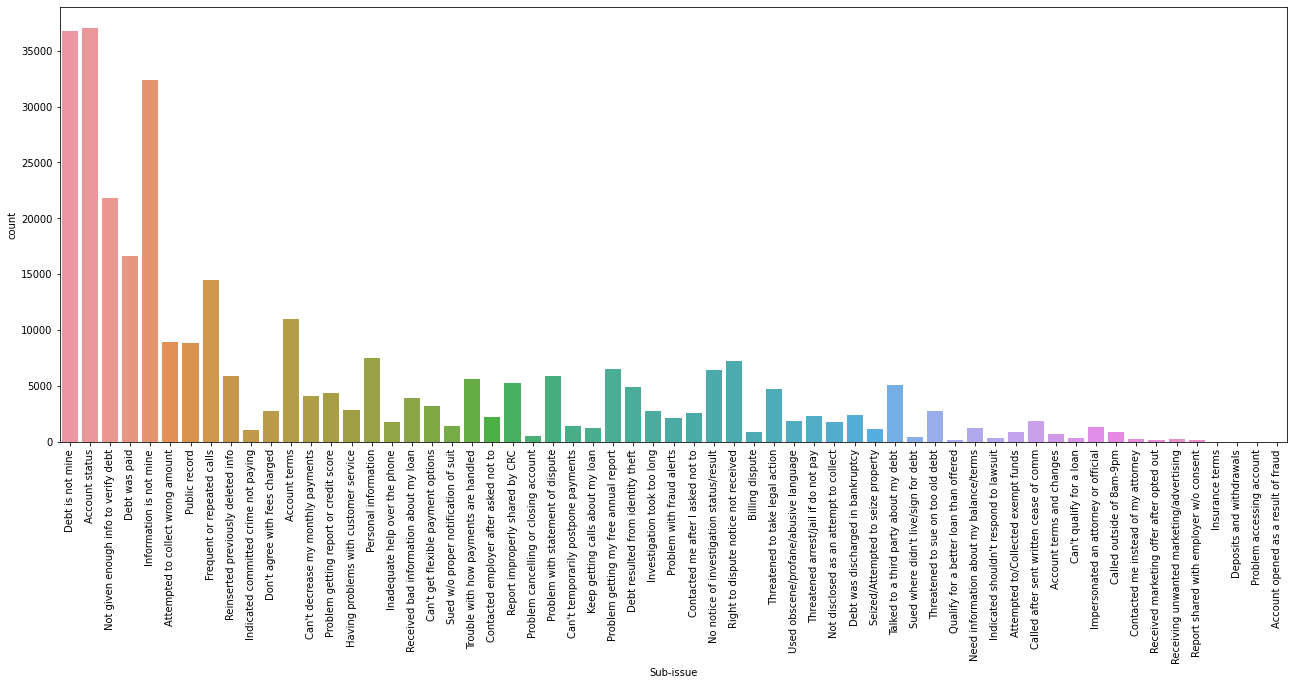

In [ ]:
# Ploting the Sub-Issue column
plt.figure(figsize=(22, 8))
sns.countplot(x=df[cat_var[3]])
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

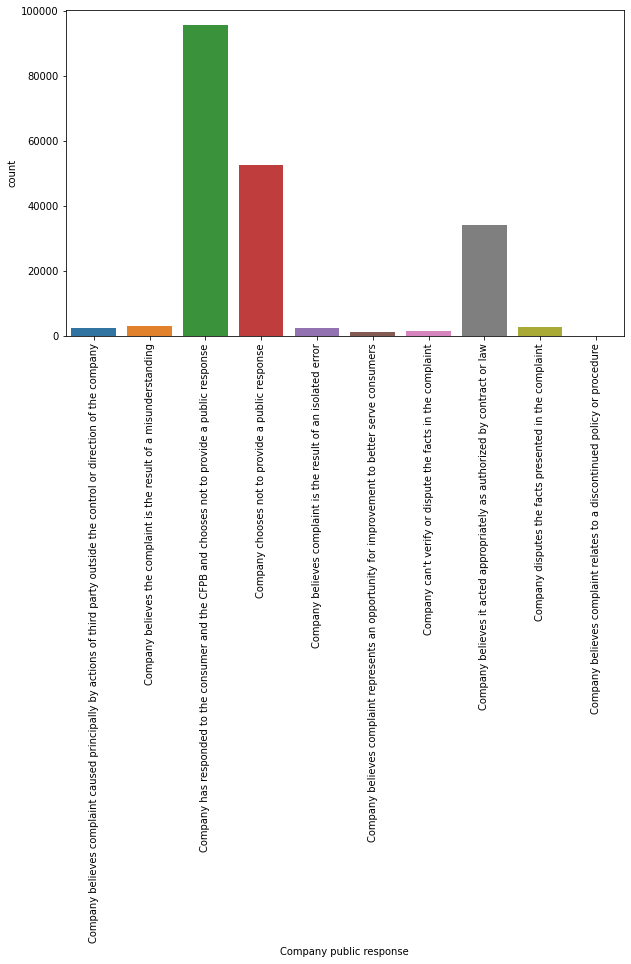

In [ ]:
# Ploting the Public response column
plt.figure(figsize=(10, 6))
sns.countplot(x=df[cat_var[4]])
plt.xticks(rotation=90)

In [ ]:
# There are more than 4200 unique company
df[[cat_var[5]]].nunique()

Company    4282
dtype: int64

([], <a list of 0 Text major ticklabel objects>)

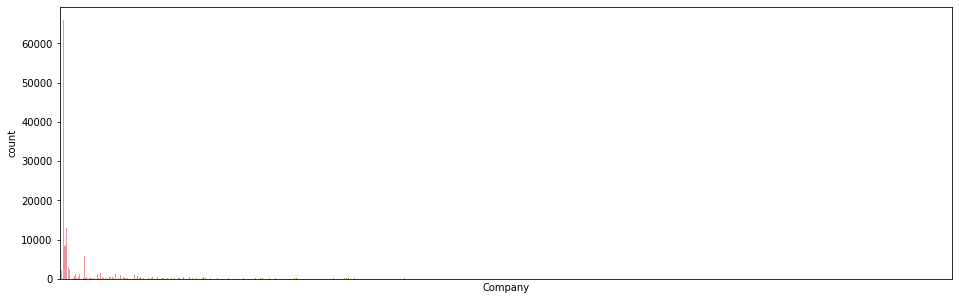

In [ ]:
# Ploting the Company column
plt.figure(figsize=(16, 5))
sns.countplot(x=df[cat_var[5]])
plt.xticks([])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 62 Text major ticklabel objects>)

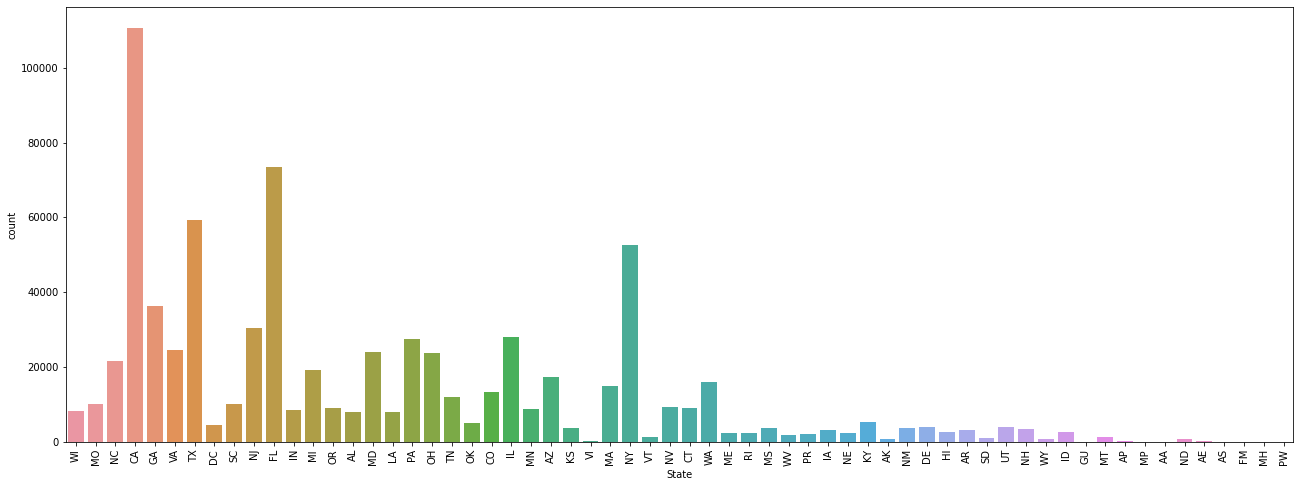

In [ ]:
# Ploting the State column
plt.figure(figsize=(22,8))
sns.countplot(x=df[cat_var[6]])
plt.xticks(rotation=90)

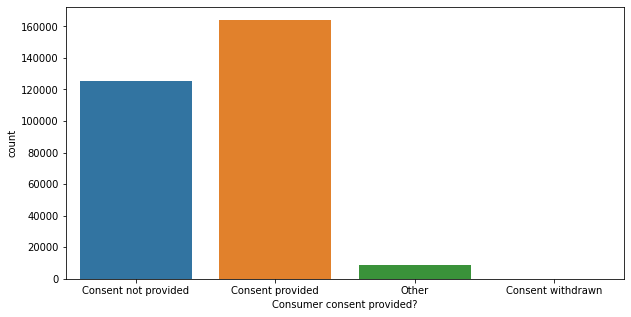

In [ ]:
# Ploting the Consumer consent provided? column
plt.figure(figsize=(10,5))
sns.countplot(x=df[cat_var[7]])

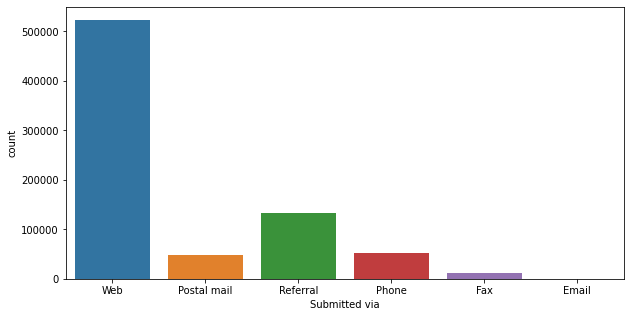

In [ ]:
# Ploting the Submitted via column
plt.figure(figsize=(10,5))
sns.countplot(x=df[cat_var[8]])

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

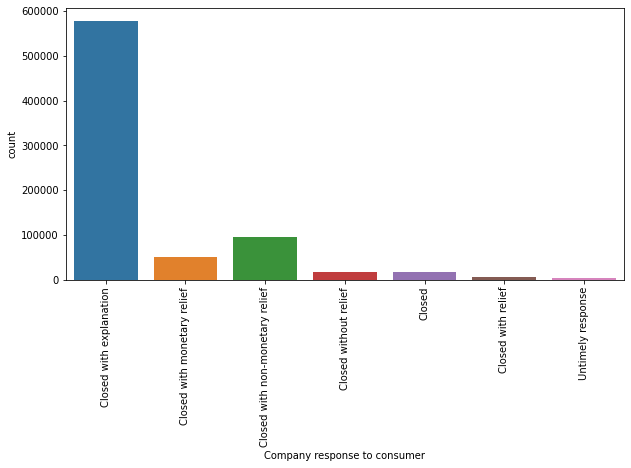

In [ ]:
# Ploting the Company Response to customer column
plt.figure(figsize=(10, 5))
sns.countplot(x=df[cat_var[9]])
plt.xticks(rotation=90)

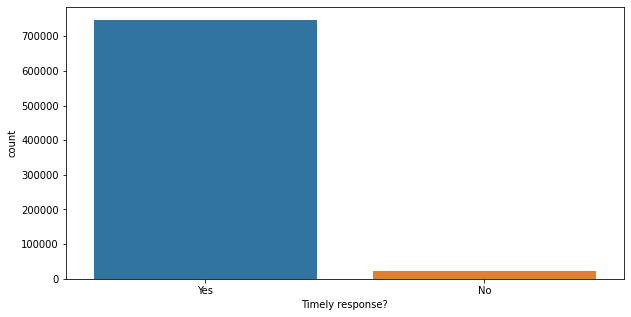

In [ ]:
# Ploting the Timely response column
plt.figure(figsize=(10, 5))
sns.countplot(x=df[cat_var[10]])

In [ ]:
# Checking how much imbalance is the dataset 
df["Consumer disputed?"].value_counts()

No     620049
Yes    148378
Name: Consumer disputed?, dtype: int64

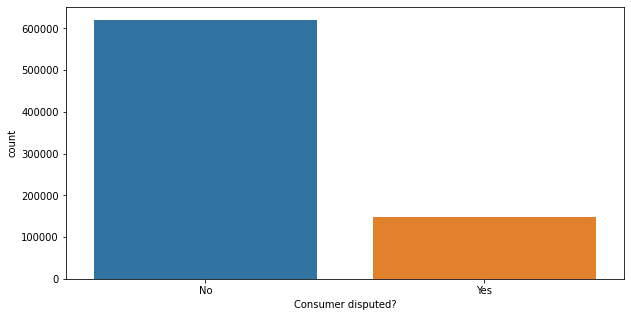

In [ ]:
# Ploting the Customer Disputed column
plt.figure(figsize=(10, 5))
sns.countplot(x=df["Consumer disputed?"])

# **Report**

* Company column has high cardinality we need to handel that.

* The target classes are highly imbalanced

* Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)

* If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model.
Hence we should handle imbalanced data with certain methods.

# **How to handle Imbalance Data ?**

* Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
* **SMOTE**: Synthetic Minority Oversampling Technique
* SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
* Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
* It only duplicates the data and it won't add and new information. Hence we look at some different techniques.



### **First Handelling the missing values by most frequent category (Mode)**

In [ ]:
# Checking nan values.
df.isna().sum()

Product                              0
Sub-product                     235162
Issue                                0
Sub-issue                       455400
Company public response         572718
Company                              0
State                             5650
Consumer consent provided?      470548
Submitted via                        0
Company response to consumer         0
Timely response?                     0
Consumer disputed?                   0
dtype: int64

In [ ]:
# Createing a function that fills the missing values by mode
def mode_imputation(df, column):
    '''
    Description :- This function takes fills the missing values in column.
    df :- Name of the dataframe.
    column :- Name of the coumn.
    '''
    mode = df[column].mode()[0]
    df[column].fillna(mode, inplace=True)


In [ ]:
# Handeling values in a loop.
for i in cat_var:
    mode_imputation(df, i)

In [ ]:
# Checking nan values.
df.isna().sum()

Product                         0
Sub-product                     0
Issue                           0
Sub-issue                       0
Company public response         0
Company                         0
State                           0
Consumer consent provided?      0
Submitted via                   0
Company response to consumer    0
Timely response?                0
Consumer disputed?              0
dtype: int64

# **Converting the cateogeries and High Cardinality categories into numerical values**

* Taking cateogeries only which is contributing 1% of the datatset size

In [ ]:
df_copy = df.copy()

In [ ]:
# Taking cateogeries only which is contributing 1% of the datatset size or else converting into rare_var
for feature in cat_var:
    temp = df.groupby(feature)["Consumer disputed?"].count() / len(df)
    temp_df = temp[temp > 0.01].index
    df[feature] = np.where(df[feature].isin(temp_df), df[feature], "rare_var")

In [ ]:
# Checking the top 10 record
df.head(10)

,Product,Sub-product,Issue,Sub-issue,Company public response,Company,State,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
0,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,rare_var,rare_var,WI,Consent not provided,Web,Closed with explanation,Yes,No
1,Credit reporting,Other mortgage,Incorrect information on credit report,Account status,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,Consent provided,Postal mail,Closed with explanation,Yes,No
2,Credit card,Other mortgage,rare_var,Account status,Company has responded to the consumer and the ...,rare_var,NC,Consent provided,Web,Closed with monetary relief,Yes,No
3,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",Account status,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,Consent provided,Web,Closed with non-monetary relief,Yes,No
4,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,rare_var,rare_var,GA,Consent provided,Postal mail,Closed with explanation,Yes,No
5,Mortgage,Conventional fixed mortgage,Settlement process and costs,Account status,Company has responded to the consumer and the ...,Ocwen Financial Corporation,WI,Consent provided,Web,Closed with explanation,Yes,No
6,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt was paid,Company has responded to the consumer and the ...,rare_var,CA,Consent provided,Web,Closed with explanation,Yes,No
7,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,Company has responded to the consumer and the ...,rare_var,VA,Consent provided,Referral,Closed with explanation,Yes,No
8,Credit reporting,Other mortgage,Incorrect information on credit report,Account status,Company has responded to the consumer and the ...,"EQUIFAX, INC.",CA,Consent provided,Web,Closed with explanation,Yes,No
9,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",Account status,Company has responded to the consumer and the ...,rare_var,GA,Consent provided,Web,Closed with explanation,Yes,No


In [ ]:
# Converting our target into numerical values
dt = {'Yes': 1, 'No': 0}
df["Consumer disputed?"] = df["Consumer disputed?"].map(dt)

In [ ]:
# Converting the categories into Numerical
for feature in cat_var:
    print(feature)
    labels_ordered = df.groupby([feature])["Consumer disputed?"].mean().sort_values().index
    labels_ordered = {k:i for i, k in enumerate(labels_ordered, 0)}
    df[feature] = df[feature].map(labels_ordered)

Product
Sub-product
Issue
Sub-issue
Company public response
Company
State
Consumer consent provided?
Submitted via
Company response to consumer
Timely response?


In [ ]:
# Checking the data
df.head(5)

,Product,Sub-product,Issue,Sub-issue,Company public response,Company,State,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
0,2,10,6,4,0,7,19,1,5,4,1,0
1,1,4,2,8,2,1,10,2,0,4,1,0
2,5,4,12,8,2,7,18,2,5,1,1,0
3,7,14,19,8,2,13,21,2,5,2,1,0
4,2,0,16,7,0,7,7,2,0,4,1,0


In [ ]:
# Sepreating the dependent and independent column
X = df.drop(columns="Consumer disputed?")
y = df["Consumer disputed?"]

In [ ]:
# Checking the shape of the dataset
X.shape, y.shape

((768427, 11), (768427,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def model_evaluation(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    results = {"Accuracy":acc,"Recall" : recall, "Precision" : precision,"F1" : f1, "AUC ROC" : roc_auc}
    return results

In [ ]:
# scalar = StandardScaler()
# scalar.fit(X_train)

In [ ]:
# X_train = pd.DataFrame(scalar.transform(X_train),columns=X_train.columns)
# X_test = pd.DataFrame(scalar.transform(X_test),columns=X_test.columns)

In [ ]:
from imblearn.combine import SMOTETomek
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=49, sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_train, y_train = smt.fit_resample(X_train, y_train)

In [ ]:
scalar = StandardScaler()
scalar.fit(X_train)

StandardScaler()

In [ ]:
X_train = pd.DataFrame(scalar.transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scalar.transform(X_test),columns=X_test.columns)

In [ ]:
X_train.shape, y_train.shape

((990102, 11), (990102,))

In [ ]:
X_test.shape, y_test.shape

((153686, 11), (153686,))

In [ ]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, oob_score=True)

In [ ]:
rf.score(X_test, y_test)

0.5808857020157985

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
model_evaluation(y_test, y_pred_rf)

{'Accuracy': 0.5808857020157985,
 'Recall': 0.5315819841835523,
 'Precision': 0.23632550208984052,
 'F1': 0.32719144313528875,
 'AUC ROC': 0.5620807290970006}

In [ ]:
xgb = XGBClassifier(n_estimators=200)

In [ ]:
xgb.fit(X_train, y_train)

XGBClassifier(n_estimators=200)

In [ ]:
xgb.score(X_test, y_test)

0.5193381309943651

In [ ]:
confusion_matrix(y_test, y_pred_rf)

array([[73612, 50611],
       [13801, 15662]])

In [ ]:
y_pred = xgb.predict(X_test)

In [ ]:
model_evaluation(y_test, y_pred)

{'Accuracy': 0.5193381309943651,
 'Recall': 0.6867936055391508,
 'Precision': 0.23840099908103396,
 'F1': 0.35394128090536203,
 'AUC ROC': 0.5832074658512914}

In [ ]:
model = Sequential()
model.add(Dense(units=11, activation="relu"))

model.add(Dense(units=9, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(units=5, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation="sigmoid"))

In [ ]:
optmizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [ ]:
model.compile(optimizer=optmizer, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=25,
    verbose=2,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


In [ ]:
model_history = model.fit(X_train, y_train, validation_split = 0.33, batch_size=10, epochs=1)

66337/66337 [==============================] - 210s 3ms/step - loss: 0.5697 - accuracy: 0.7463 - val_loss: 1.3820 - val_accuracy: 0.0000e+00


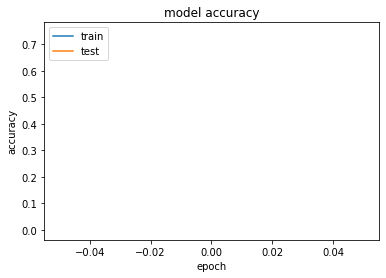

In [ ]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

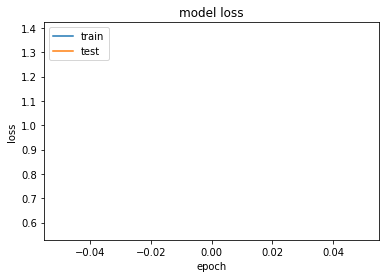

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

4803/4803 [==============================] - 7s 2ms/step


In [ ]:
# check_point_path = "model_ckp.h5"
# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(check_point_path, save_best_only=True)

In [ ]:
y_pred = (y_pred > 0.5)

In [ ]:
model_evaluation(y_test, y_pred)

{'Accuracy': 0.8082909308590243,
 'Recall': 0.0,
 'Precision': 0.0,
 'F1': 0.0,
 'AUC ROC': 0.5}

In [ ]:
confusion_matrix(y_test, y_pred)

array([[124223,      0],
       [ 29463,      0]])